In [1]:
import torch
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch.utils.data import Dataset

from utilities import *
import os


os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device='cuda'


In [2]:
focal, all_c2w, all_gt = get_data("../lego")
H, W = all_gt[0].shape[:2]

LOAD DATA ../lego/train


100%|█████████████████████████████████████████| 100/100 [00:02<00:00, 48.52it/s]


In [3]:
class VoxelGrid():
    def __init__(self, size=128, bound_w=1):
        self.size = size
        self.bound_w = bound_w
        self.colors =  Variable(torch.rand((size*size*size,3)).to(device), requires_grad=True)
        self.opacities =  Variable(torch.rand((size*size*size)).to(device), requires_grad=True)
        x = np.linspace(-bound_w,bound_w,size)
        y = np.linspace(-bound_w,bound_w,size)
        z = np.linspace(-bound_w,bound_w,size)
        self.meshgrid = np.meshgrid(x,y,z)

    def in_bounds_indices(self, p):
        ''' input: Nx3 array
            output: index of valid arrays'''
        in_x = (p[...,0]>=0)*(p[...,0]<self.size)
        in_y = (p[...,1]>=0)*(p[...,1]<self.size)
        in_z = (p[...,2]>=0)*(p[...,2]<self.size)
        return in_x*in_y*in_z
    
    def descartes_to_indices(self, p):
        ''' input: Nx3 array, 3D points
            out: Nx3 array, 3D indices in [0, size['''
        q = torch.zeros_like(p)
        q[..., 0] = (p[...,0]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[..., 1] = (p[...,1]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        q[..., 2] = (p[...,2]+self.bound_w)/(2*self.bound_w)*(self.size-1)
        return q

    def flatten_3d_indices(self, inds_3d):
        ''' input: Nx3 array of indices
            out: N array of flatten indices'''
        return inds_3d[...,0] + self.size*inds_3d[...,1] + self.size*self.size*inds_3d[...,2]

    def render_ray(self, p):
        # extract valid indices
        inds_3d = self.descartes_to_indices(p)
        valid_inds = torch.arange(len(p))[self.in_bounds_indices(torch.floor(inds_3d))]

        # meshgrid coordinates
        mesh_coords = self.flatten_3d_indices(inds_3d[valid_inds].long())

        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]
        cumsum_opacities = torch.cumsum(opacities, 0)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(0)
    
    def render_rays(self, p):
        # extract valid indices
        inds_3d = self.descartes_to_indices(p)
        in_bounds = self.in_bounds_indices(torch.floor(inds_3d).to(device))
        # meshgrid coordinates
        mesh_coords = self.flatten_3d_indices(inds_3d.long())
        mesh_coords[torch.logical_not(in_bounds)] = 0
        
        colors = self.colors[mesh_coords]
        opacities = self.opacities[mesh_coords]*in_bounds.float()
        cumsum_opacities = torch.cumsum(opacities, 1)
        
        transp_term = torch.exp(-cumsum_opacities)*(1-torch.exp(-opacities))
        return (colors*transp_term[..., None]).sum(1)

    def update_grads(self, lr):
        self.colors.data -= lr * self.colors.grad.data
        self.colors.grad.data.zero_()
        self.opacities.data -= lr * self.opacities.grad.data
        self.opacities.grad.data.zero_()
    
    def copy():
        # TODO
        pass 

In [131]:
red = 32
target_ims = [gt[::red,::red,:] for gt in all_gt]
rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]
N_points=100
rays = [e[0][::red,::red,:, None] + np.arange(N_points)/10*e[1][::red, ::red,:, None] for e in rays_or_dir]

In [132]:
im_w = target_ims[0].shape[0]
im_w


25

In [138]:
class RayDataset(Dataset):
    def __init__(self, target_ims, rays):
        self.im_w = target_ims[0].shape[0]

        self.tensor_rays = []
        self.tensor_target_pixels = []
        
        for image_ind in range(im_w):
            for i in range(im_w):
                for j in range(im_w):
                    self.tensor_rays.append(torch.tensor(rays[image_ind][i,j], dtype=torch.float32).to(device).T)
                    self.tensor_target_pixels.append(torch.tensor(target_ims[image_ind][i,j], dtype=torch.float32).to(device))

    def __getitem__(self, index):
        return self.tensor_rays[index], self.tensor_target_pixels[index]
    def __len__(self):
        return len(self.tensor_rays)

D = RayDataset(target_ims, rays)

In [60]:
VG = VoxelGrid(40, 1)

In [139]:

train_loader = torch.utils.data.DataLoader(D, batch_size=10000, shuffle=True)



In [167]:
def train():
    losses=[]
    for batch_idx, (rays, pixels) in enumerate(train_loader):
        pix_estims = VG.render_rays(rays)
        loss = ((pix_estims-pixels)**2).sum()/rays.shape[0]
        loss.backward()
        losses.append(loss.item())
        VG.update_grads(500)
    return losses

for i in tqdm(range(10)):
    train()

100%|███████████████████████████████████████████| 10/10 [00:23<00:00,  2.30s/it]


In [170]:
red = 4
target_ims = [gt[::red,::red,:] for gt in all_gt]
rays_or_dir = [get_rays_np(H,W, focal, c2w) for c2w in all_c2w]
N_points=100
rays = [e[0][::red,::red,:, None] + np.arange(N_points)/10*e[1][::red, ::red,:, None] for e in rays_or_dir]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


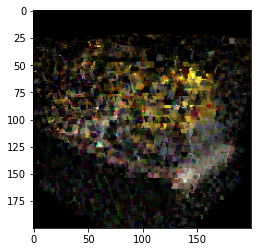

In [171]:
image_ind=4
im_w = target_ims[0].shape[0]
tensor_rays_img = torch.tensor(rays[image_ind], dtype=torch.float32).to(device).permute((0,1,3,2)).view((im_w*im_w,N_points,3))

new_im = VG.render_rays(tensor_rays_img).view((im_w,im_w,3)).cpu().detach().numpy()

plt.imshow(new_im)

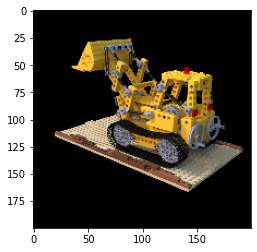

In [172]:
plt.imshow(target_ims[image_ind])

(array([7.9800e+02, 1.1930e+04, 2.2843e+04, 1.8450e+04, 8.8300e+03,
        1.1010e+03, 4.4000e+01, 1.0000e+00, 0.0000e+00, 3.0000e+00]),
 array([-0.61912161, -0.2462488 ,  0.12662401,  0.49949682,  0.87236964,
         1.24524245,  1.61811526,  1.99098807,  2.36386088,  2.73673369,
         3.1096065 ]),
 <BarContainer object of 10 artists>)

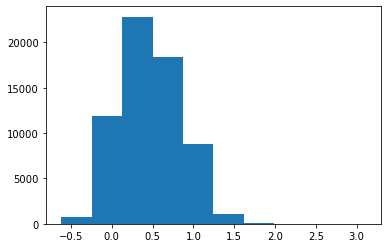

In [106]:
plt.hist(VG.opacities.tolist())

In [107]:
VG2 = VG.copy()

AttributeError: 'VoxelGrid' object has no attribute 'copy'